In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
import math
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,4)

In [37]:
Fs = 20000 #sampling freq. in hz
Fc = 1000 #frequency of carrier signal
baud_rate = 500 #need to be less than Fc
data_size = 160 * 8 #160 bytes of text
T = (data_size/baud_rate) #length in sec
sample_per_bit = int(Fs/baud_rate)
print(T)
print(sample_per_bit)

2.56
40


In [81]:
#arbitray data
data = np.random.randint(low = 0, high = 2, size = data_size) 
data[data==0] = -1
print(data)

[ 1  1  1 ...  1  1 -1]


In [84]:
#upsample data :
data_tx = np.repeat(data,sample_per_bit)
#modulate carrier with data :
tx_signal = np.sin(np.arange(0, len(data_tx)) * 2 *np.pi * (Fc/Fs)) * data_tx 

<StemContainer object of 3 artists>

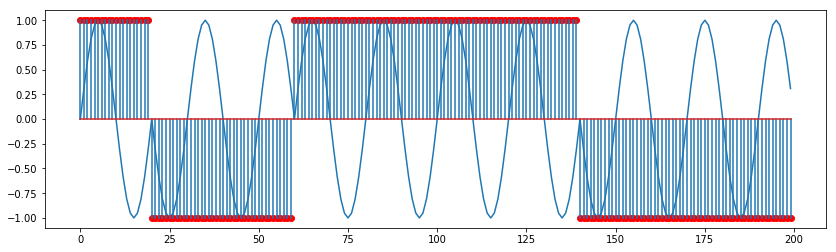

In [85]:
#plot first samples of tx_signal
plt.plot(tx_signal[100:300])
plt.stem(data_tx[100:300],markerfmt = 'ro')

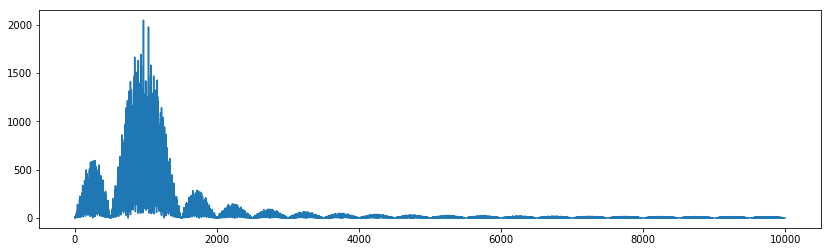

In [86]:
tx_fft = np.abs(np.fft.fft(tx_signal))
N = int(len(tx_fft)/2)
plt.plot(np.linspace(0,1,N) * (Fs/2), tx_fft[0:N]);

In [87]:
#modulate signal
modulation_freq = 5000 #modulation frequency in hertz
tx_signal_modulated = tx_signal * np.cos(np.arange(0,len(tx_signal)) * 2 * np.pi * (modulation_freq/Fs))

In [88]:
# channel
noise = noise = np.random.normal(0,0.05,len(tx_signal_modulated))
rx_signal = tx_signal_modulated + noise

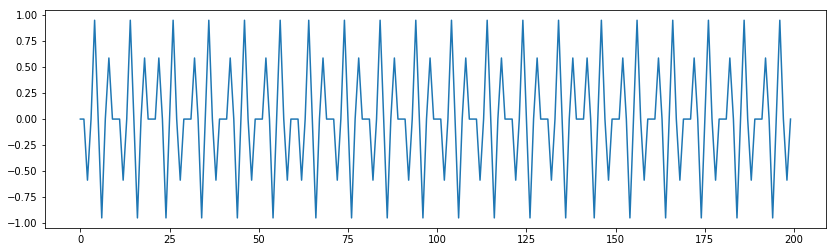

In [89]:
plt.plot(tx_signal_modulated[100:300])

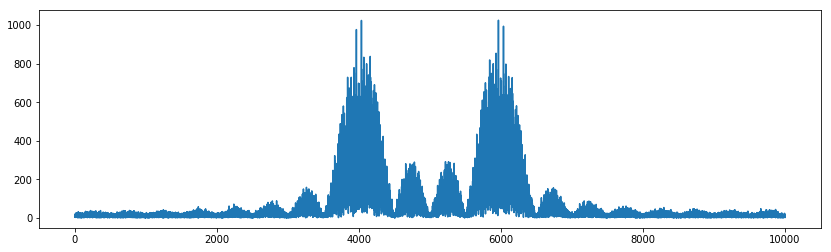

In [90]:
N = int(len(rx_signal)/2)
rx_fft = np.abs(np.fft.fft(rx_signal))
plt.plot(np.linspace(0,1,N) * (Fs/2), rx_fft[0:N]);

In [113]:
#lowpass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sp.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=20):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sp.filtfilt(b, a, data)
    return y

In [114]:
#demodulate signal
rx_signal_demod =  rx_signal * np.cos(2 * np.pi * (modulation_freq/Fs) * np.arange(0,len(rx_signal)))
#filter signal
rx_signal_demod = butter_lowpass_filter(rx_signal_demod,Fc + 500, Fs, 20)

/Users/Valentin/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


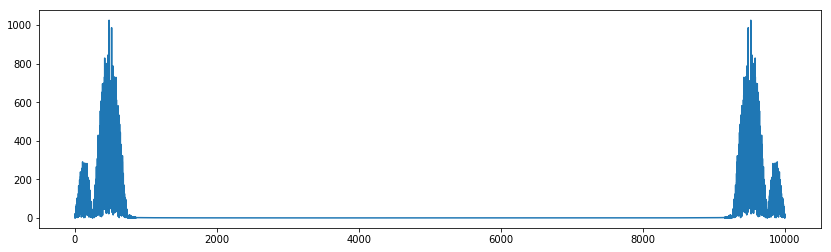

In [115]:
rx_demod_fft = np.abs(np.fft.fft(rx_signal_demod))
N = int(len(rx_demod_fft))
plt.plot(np.linspace(0,1,N) * (Fs/2), rx_demod_fft[0:N]);

<StemContainer object of 3 artists>

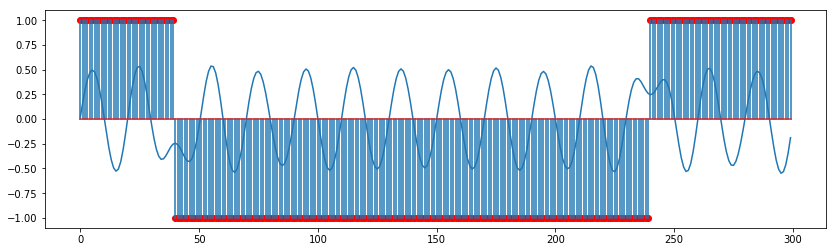

In [116]:
plt.plot(rx_signal_demod[200:500])
plt.stem(data_tx[200:500],markerfmt = 'ro')

In [119]:
#computer the inner product with the base signal to determine bit sent
pulse = np.sin(np.arange(0, len(rx_signal_demod)) * 2 *np.pi * (Fc/Fs))
signal_correlated = np.convolve(rx_signal_demod,pulse)

[ 0.         -0.00930932  0.02246614  0.13680982  0.3579069   0.68689522
  1.09964674  1.54849177  1.96776075  2.2824934 ]


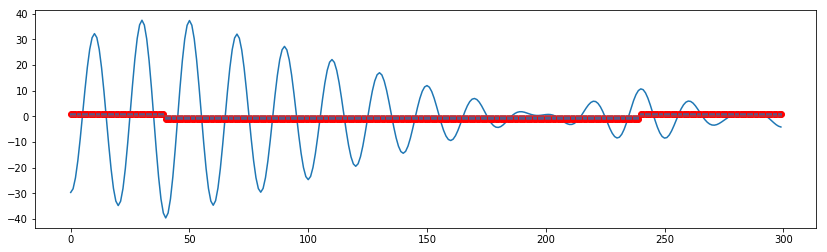

In [120]:
plt.plot(signal_correlated[200:500])
plt.stem(data_tx[200:500],markerfmt = 'ro')
print(signal_correlated[0:10])

In [ ]:
# Filter requirements.
order = 20
fs = Fs   # sample rate, Hz
cutoff = 5000  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = sp.freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()